In [2]:
from embeddings import s2v_embedding, bert_embedding, w2v_embedding, tfidf_embedding
from NeuralNetClassifier import fullyconnected as fc
from NeuralNetClassifier import print_results
import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


###### Read the correpsonding csv file

In [6]:
#uncomment following for s2v and bert model
# train = pd.read_csv('../dataset/yelp/s2v_Yelp_train.csv')
# testval = pd.read_csv('../dataset/yelp/s2v-Yelp-test_validate.csv')


#uncomment following for tf-idf
yelp = pd.read_csv('../unimelb/dataset/yelp/Yelp.csv')
train = yelp[:25000]
testval = yelp[25000:]

In [7]:
# split into test and validate set
validate, test = np.split(testval, 2)

##### use following to convert sent2vec embeddings, the input is a list of review text

In [4]:
x_train = s2v_embedding(train['sent2vec'].values)

#column name is 'stars' for Yelp! and 'rating' for Zappos dataset.
y_train = np.asarray([x-1 for x in train['stars'].values])

x_validate = s2v_embedding(validate['sent2vec'].values)
y_validate = np.asarray([x-1 for x in validate['stars'].values])

x_test = s2v_embedding(test['sent2vec'].values)
y_test = np.asarray([x-1 for x in test['stars'].values])

##### use following to convert BERT embeddings, the input is a list of review text

In [ ]:
x_train = bert_embedding(train['bert'].values)

#column name is 'stars' for Yelp! and 'rating' for Zappos dataset.
y_train = np.asarray([x-1 for x in train['stars'].values]) 

x_validate = bert_embedding(validate['bert'].values)
y_validate = np.asarray([x-1 for x in validate['stars'].values])

x_test = bert_embedding(test['bert'].values)
y_test = np.asarray([x-1 for x in test['stars'].values])

###### use following to convert tf-idf embeddings, the input is a Series of review text

In [4]:
def clean_text(df, col):
    """A function for keeping only alpha-numeric
    characters and replacing all white space with
    a single space.
    """
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', str(x).lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

In [8]:
#column name 'text' for Yelp!, 'review content' for Zappos
x_train = tfidf_embedding(clean_text(train, 'text'))
x_validate = tfidf_embedding(clean_text(validate, 'text'))
x_test = tfidf_embedding(clean_text(test, 'text'))

y_train = np.asarray([x-1 for x in train['stars'].values])
y_validate = np.asarray([x-1 for x in validate['stars'].values])
y_test = np.asarray([x-1 for x in test['stars'].values])

##### train the nn classifier with fc layer
the parameters are (dimension, training set embeddings, training set labels, validate set embeddings, validate set labels)

dimension for s2v is 600 for s2v, 768 for BERT, 300 for w2v, and 300 for tf-idf for our project

In [9]:
model = fc(300, x_train, y_train, x_validate, y_validate)

Instructions for updating:
Colocations handled automatically by placer.
Train on 25000 samples, validate on 10000 samples
Epoch 1/25
25000/25000 [==============================] - 1s 43us/step - loss: 1.6038 - accuracy: 0.2270 - categorical_accuracy: 0.2419 - val_loss: 1.5971 - val_accuracy: 0.2901 - val_categorical_accuracy: 0.1928
Epoch 2/25
25000/25000 [==============================] - 1s 56us/step - loss: 1.5713 - accuracy: 0.2804 - categorical_accuracy: 0.2576 - val_loss: 1.5708 - val_accuracy: 0.3451 - val_categorical_accuracy: 0.4214
Epoch 3/25
25000/25000 [==============================] - 1s 34us/step - loss: 1.4977 - accuracy: 0.3314 - categorical_accuracy: 0.3009 - val_loss: 1.5076 - val_accuracy: 0.4014 - val_categorical_accuracy: 0.3869
Epoch 4/25
25000/25000 [==============================] - 1s 33us/step - loss: 1.4016 - accuracy: 0.3856 - categorical_accuracy: 0.2886 - val_loss: 1.4696 - val_accuracy: 0.4030 - val_categorical_accuracy: 0.3544
Epoch 5/25
25000/25000 [==

In [10]:
#predict the labels for the test set
y_pred = model.predict(x_test, batch_size=128)

##### print the result

In [11]:
print_results(y_test, y_pred)

F1 score: 0.1887
[[ 603  424   92  104  184]
 [ 308  352   81   59   53]
 [ 370  478  115   56   72]
 [ 760  849  209  172  204]
 [1576 1415  420  399  645]]


##### option to plot the roc-auc curve for a given prediction

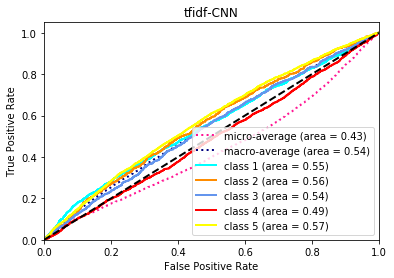

In [13]:
from NeuralNetClassifier import roc_auc_plot
import keras

y_true = keras.utils.to_categorical(y_test, num_classes=5)
plt = roc_auc_plot(y_true, y_pred, title='tfidf-CNN')

# plt.savefig('./s2v-cnn.png', dpi=300)

##### train and predict using SVM classifier

In [14]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score

#initialise SVM
svm = LinearSVC(dual=False, max_iter=5000)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [15]:
print("F1 score: {}".format(f1_score(y_test, y_pred, average='micro')))
confusion_matrix(y_test, y_pred)

F1 score: 0.1872


array([[ 503,  437,  146,  134,  187],
       [ 254,  363,   88,   92,   56],
       [ 305,  500,  124,   89,   73],
       [ 636,  849,  291,  218,  200],
       [1360, 1271,  812,  348,  664]])